# Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
from torchsummary import summary

import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm
import time
import os
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Bora

In [2]:
path = '/content/drive/MyDrive/Doutorado Unicamp/Projeto/github/tcgan/raw-data/UCR_TS_Archive_2015/Fish/Fish_TRAIN.txt'
data_train = np.genfromtxt(path, delimiter=',', dtype=np.float32)
path = '/content/drive/MyDrive/Doutorado Unicamp/Projeto/github/tcgan/raw-data/UCR_TS_Archive_2015/Fish/Fish_TEST.txt'
data_test = np.genfromtxt(path, delimiter=',', dtype=np.float32)
print(data_train.shape, data_test.shape)

(175, 464) (175, 464)


In [3]:
# parse
x_tr = data_train[:, :-1]
y_tr = data_train[:, -1].astype(int)
x_te = data_test[:, :-1]
y_te = data_test[:, -1].astype(int)
y_all = np.concatenate([y_tr, y_te])
classes, y_all = np.unique(y_all, return_inverse=True)
n_class = len(classes)
x_tr = x_tr[..., np.newaxis]
x_te = x_te[..., np.newaxis]

# all data can be used in unsupervised learning
x_all = np.vstack([x_tr, x_te])
_, x_te_gan, _, _ = train_test_split(
    x_all, y_all, train_size=0.9, random_state=42, stratify=y_all)
x_tr_gan = x_all  # use all

In [4]:
input_shape = x_tr.shape[1:]
input_shape

(463, 1)

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
generated_sample_shape = input_shape
noise_shape = 100
input_layer = noise_shape

n_layers = 4
kernel_size = 10
strides = 2
g_units_base=32

steps = generated_sample_shape[0]
layer_steps = [steps]
for i in range(n_layers):
    layer_steps.append(int(np.ceil(float(layer_steps[-1]) / float(strides))))
layer_steps.reverse()

conv_units = []
if n_layers > 1:
    conv_units.append(g_units_base)
    for _ in range(n_layers - 2):  # minus the first and the last layers
        conv_units.append(conv_units[-1] * 2)
conv_units.reverse()
# the last layer must be aligned to the number of dimensions of input.
conv_units.append(generated_sample_shape[-1])

In [7]:
generator = nn.Sequential(
    nn.Linear(input_layer, layer_steps[0] * conv_units[0] * 2, device=device),
    nn.BatchNorm1d(layer_steps[0] * conv_units[0] * 2, device=device),
    nn.ReLU(),
    nn.Unflatten(1, (conv_units[0] * 2, layer_steps[0])),

    nn.ConvTranspose1d(conv_units[0] * 2, conv_units[0], kernel_size,
                                stride=strides, padding=4, device=device),
    nn.BatchNorm1d(conv_units[0], device=device),
    nn.ReLU(),
    nn.ConvTranspose1d(conv_units[0], conv_units[1], kernel_size,
                                stride=strides, padding=4, device=device),
    nn.BatchNorm1d(conv_units[1], device=device),
    nn.ReLU(),
    nn.ConvTranspose1d(conv_units[1], conv_units[2], kernel_size,
                                stride=strides, padding=4, device=device),
    nn.BatchNorm1d(conv_units[2], device=device),
    nn.ReLU(),
    nn.ConvTranspose1d(conv_units[2], conv_units[3], kernel_size,
                                stride=strides, padding=5, output_padding=1, device=device)
    )
generator[0].weight = nn.init.trunc_normal_(generator[0].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
generator[4].weight = nn.init.trunc_normal_(generator[4].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
generator[7].weight = nn.init.trunc_normal_(generator[7].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
generator[10].weight = nn.init.trunc_normal_(generator[10].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
generator[13].weight = nn.init.trunc_normal_(generator[13].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)

In [8]:
z = torch.randn(15, 100).to(device)
aux = generator(z)
aux.shape

torch.Size([15, 1, 463])

In [9]:
px.line(aux.squeeze().cpu().detach().numpy().T)

In [10]:
summary(generator, (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 7424]         749,824
       BatchNorm1d-2                 [-1, 7424]          14,848
              ReLU-3                 [-1, 7424]               0
         Unflatten-4              [-1, 256, 29]               0
   ConvTranspose1d-5              [-1, 128, 58]         327,808
       BatchNorm1d-6              [-1, 128, 58]             256
              ReLU-7              [-1, 128, 58]               0
   ConvTranspose1d-8              [-1, 64, 116]          81,984
       BatchNorm1d-9              [-1, 64, 116]             128
             ReLU-10              [-1, 64, 116]               0
  ConvTranspose1d-11              [-1, 32, 232]          20,512
      BatchNorm1d-12              [-1, 32, 232]              64
             ReLU-13              [-1, 32, 232]               0
  ConvTranspose1d-14               [-1,

In [11]:
units = [32]
for _ in range(n_layers - 1):  # exclude the first layer.
    units.append(units[-1] * 2)

In [12]:
discriminator = nn.Sequential(
    nn.Conv1d(input_shape[-1], units[0], kernel_size,
                                stride=strides, padding=5, device=device),
    nn.LeakyReLU(0.2),
    nn.Conv1d(units[0], units[1], kernel_size,
                                stride=strides, padding=4, device=device),
    nn.LeakyReLU(0.2),
    nn.Conv1d(units[1], units[2], kernel_size,
                                stride=strides, padding=4, device=device),
    nn.BatchNorm1d(units[2], device=device),
    nn.LeakyReLU(0.2),
    nn.Conv1d(units[2], units[3], kernel_size,
                                stride=strides, padding=4, device=device),
    nn.BatchNorm1d(units[3], device=device),
    nn.LeakyReLU(0.2),
    nn.Flatten(),
    nn.Linear(layer_steps[0] * units[-1], 1, device=device)
    )
discriminator[0].weight = nn.init.trunc_normal_(discriminator[0].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
discriminator[2].weight = nn.init.trunc_normal_(discriminator[2].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
discriminator[4].weight = nn.init.trunc_normal_(discriminator[4].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
discriminator[7].weight = nn.init.trunc_normal_(discriminator[7].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
discriminator[11].weight = nn.init.trunc_normal_(discriminator[11].weight, mean=0.0, std=0.02, a=-0.04, b=0.04)

In [13]:
summary(discriminator, (1,463))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 232]             352
         LeakyReLU-2              [-1, 32, 232]               0
            Conv1d-3              [-1, 64, 116]          20,544
         LeakyReLU-4              [-1, 64, 116]               0
            Conv1d-5              [-1, 128, 58]          82,048
       BatchNorm1d-6              [-1, 128, 58]             256
         LeakyReLU-7              [-1, 128, 58]               0
            Conv1d-8              [-1, 256, 29]         327,936
       BatchNorm1d-9              [-1, 256, 29]             512
        LeakyReLU-10              [-1, 256, 29]               0
          Flatten-11                 [-1, 7424]               0
           Linear-12                    [-1, 1]           7,425
Total params: 439,073
Trainable params: 439,073
Non-trainable params: 0
-------------------------------

# Mais

In [69]:
X_train = torch.tensor(np.swapaxes(x_tr_gan,1,2), dtype=torch.float32, device=device).detach()

In [19]:
generator = generator.to(device)
discriminator = discriminator.to(device)

# torch.manual_seed(42)

loss_fc = nn.BCEWithLogitsLoss()
sig = nn.Sigmoid()

g_opt = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

n_epochs = 300   # number of epochs to run
batch_size = 16  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

dLoss = []
gLoss = []
acc = []

z_batch = torch.randn(X_train.shape[0], noise_shape, device=device).detach()
generated_samples = generator(z_batch)
fake_logits = discriminator(generated_samples)
real_logits = discriminator(X_train)
real_loss = loss_fc(torch.ones_like(real_logits), real_logits)
fake_loss = loss_fc(torch.zeros_like(fake_logits), fake_logits)
d_loss = real_loss + fake_loss
g_loss = loss_fc(torch.ones_like(fake_logits), fake_logits)
gLoss.append(float(g_loss))
dLoss.append(float(d_loss))

real_prob = sig(real_logits)
fake_prob = sig(fake_logits)
y_real = torch.ones_like(real_prob)
y_fake = torch.zeros_like(fake_prob)
y = torch.cat((y_real, y_fake), axis=0)
y_pred = torch.cat((real_prob, fake_prob), axis=0)
acc.append(float(torch.mean(((y_pred>.5).double() == y).double())))

# training loop
for epoch in range(n_epochs):
    generator.train()
    discriminator.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size,:,:]
            z_batch = torch.randn(batch_size, noise_shape, device=device).detach()
            # generator pass
            generated_samples = generator(z_batch)
            fake_logits = discriminator(generated_samples)
            g_loss = loss_fc(torch.ones_like(fake_logits), fake_logits)
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()
            # discriminator pass
            generated_samples = generator(z_batch)
            fake_logits = discriminator(generated_samples)
            real_logits = discriminator(X_batch)
            # check acc
            real_prob = sig(real_logits)
            fake_prob = sig(fake_logits)
            y_real = torch.ones_like(real_prob)
            y_fake = torch.zeros_like(fake_prob)
            y = torch.cat((y_real, y_fake), axis=0)
            y_pred = torch.cat((real_prob, fake_prob), axis=0)
            if torch.mean(((y_pred>.5).double() == y).double()) <= 0.75:
                real_loss = loss_fc(torch.ones_like(real_logits), real_logits)
                fake_loss = loss_fc(torch.zeros_like(fake_logits), fake_logits)
                d_loss = real_loss + fake_loss
                d_opt.zero_grad()
                d_loss.backward()
                d_opt.step()
            # print progress
            bar.set_postfix(loss=float(g_loss))
    generator.eval()
    discriminator.eval()
    z_batch = torch.randn(X_train.shape[0], noise_shape, device=device).detach()
    generated_samples = generator(z_batch)
    fake_logits = discriminator(generated_samples)
    real_logits = discriminator(X_train)
    real_loss = loss_fc(torch.ones_like(real_logits), real_logits)
    fake_loss = loss_fc(torch.zeros_like(fake_logits), fake_logits)
    d_loss = real_loss + fake_loss
    g_loss = loss_fc(torch.ones_like(fake_logits), fake_logits)
    gLoss.append(float(g_loss))
    dLoss.append(float(d_loss))
    real_prob = sig(real_logits)
    fake_prob = sig(fake_logits)
    y_real = torch.ones_like(real_prob)
    y_fake = torch.zeros_like(fake_prob)
    y = torch.cat((y_real, y_fake), axis=0)
    y_pred = torch.cat((real_prob, fake_prob), axis=0)
    acc.append(float(torch.mean(((y_pred>.5).double() == y).double())))

fig = go.Figure()

fig.add_trace(go.Scatter(y=dLoss, mode="lines", showlegend=True, name='dLoss'))
fig.add_trace(go.Scatter(y=gLoss, mode="lines", showlegend=True, name='gLoss'))
fig.add_trace(go.Scatter(y=acc, mode="lines", showlegend=True, name='acc'))

fig.show()

Epoch 299: 100%|██████████| 22/22 [00:00<00:00, 51.78batch/s, loss=-2.83e+4]


In [20]:
z_batch = torch.randn(batch_size, noise_shape, device=device).detach()
generated_samples = generator(z_batch).cpu().detach().numpy()

In [24]:
px.line(generated_samples[:,0,:].T)

# debugging

In [14]:
import matplotlib.pyplot as plt

In [33]:
summary(generator, (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 7424]         749,824
       BatchNorm1d-2                 [-1, 7424]          14,848
              ReLU-3                 [-1, 7424]               0
         Unflatten-4              [-1, 256, 29]               0
   ConvTranspose1d-5              [-1, 128, 58]         327,808
       BatchNorm1d-6              [-1, 128, 58]             256
              ReLU-7              [-1, 128, 58]               0
   ConvTranspose1d-8              [-1, 64, 116]          81,984
       BatchNorm1d-9              [-1, 64, 116]             128
             ReLU-10              [-1, 64, 116]               0
  ConvTranspose1d-11              [-1, 32, 232]          20,512
      BatchNorm1d-12              [-1, 32, 232]              64
             ReLU-13              [-1, 32, 232]               0
  ConvTranspose1d-14               [-1,

In [57]:
batch = x_tr_gan[:16,:,:]
aux = np.loadtxt('/content/drive/MyDrive/Doutorado Unicamp/Projeto/github/tcgan/noise.txt', delimiter=',')
z_batch = torch.tensor(aux, device=device, dtype=torch.float32).detach()
generated_samples = generator(z_batch).cpu().detach().numpy()

In [42]:
aux = z_batch
for i in range(len(generator)):
    aux = generator[i](aux)
    print(aux.shape)

torch.Size([16, 7424])
torch.Size([16, 7424])
torch.Size([16, 7424])
torch.Size([16, 256, 29])
torch.Size([16, 128, 58])
torch.Size([16, 128, 58])
torch.Size([16, 128, 58])
torch.Size([16, 64, 116])
torch.Size([16, 64, 116])
torch.Size([16, 64, 116])
torch.Size([16, 32, 232])
torch.Size([16, 32, 232])
torch.Size([16, 32, 232])
torch.Size([16, 1, 463])


In [40]:
torch.mean(generator[0](z_batch), axis=1)

tensor([ 0.0008, -0.0016,  0.0005,  0.0010,  0.0030,  0.0019, -0.0022, -0.0009,
         0.0007, -0.0010, -0.0025, -0.0018,  0.0004, -0.0005,  0.0008,  0.0017],
       device='cuda:0', grad_fn=<MeanBackward1>)

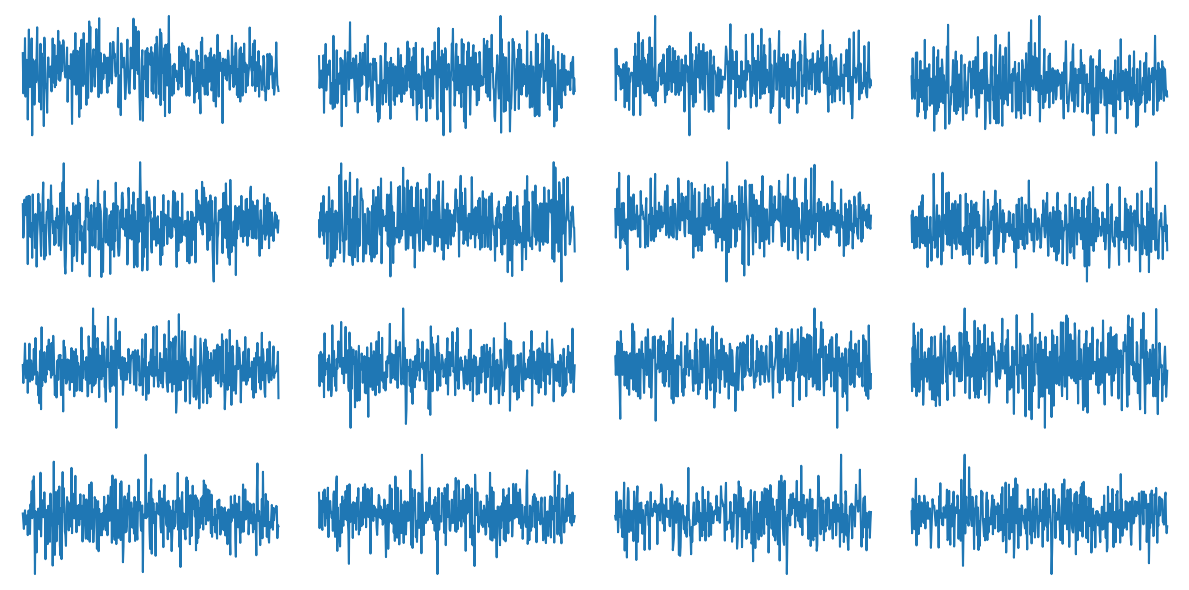

In [25]:
fig = plt.figure(figsize=(12, 6))  # each sample takes an area of 4*2.
n_samples = 16
for i in range(n_samples):
    plt.subplot(4, 4, i + 1)
    plt.plot(generated_samples[i].T)
    plt.axis('off')
plt.tight_layout()

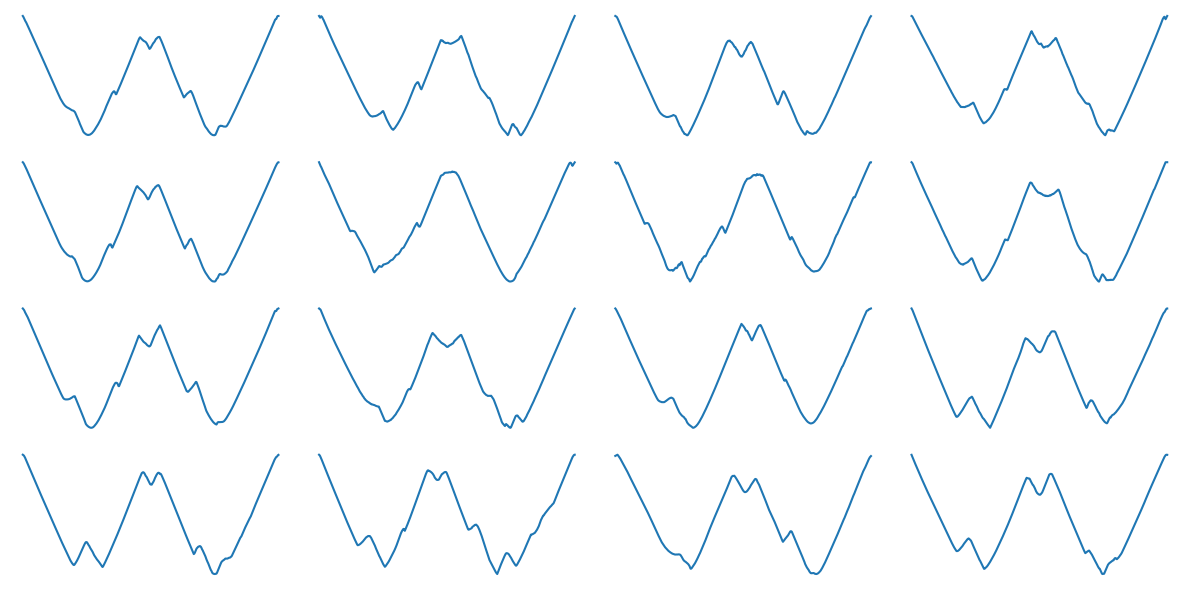

In [17]:
fig = plt.figure(figsize=(12, 6))  # each sample takes an area of 4*2.
n_samples = 16
for i in range(n_samples):
    plt.subplot(4, 4, i + 1)
    plt.plot(batch[i])
    plt.axis('off')
plt.tight_layout()

In [19]:
z_batch = torch.randn(16, noise_shape, device=device).detach()
generated_samples = generator(z_batch)
fake_logits = discriminator(generated_samples)
real_logits = discriminator(X_train)
real_loss = loss_fc(torch.ones_like(real_logits), real_logits)
fake_loss = loss_fc(torch.zeros_like(fake_logits), fake_logits)
d_loss = real_loss + fake_loss
g_loss = loss_fc(torch.ones_like(fake_logits), fake_logits)
gLoss.append(float(g_loss))
dLoss.append(float(d_loss))

real_prob = sig(real_logits)
fake_prob = sig(fake_logits)
y_real = torch.ones_like(real_prob)
y_fake = torch.zeros_like(fake_prob)
y = torch.cat((y_real, y_fake), axis=0)
y_pred = torch.cat((real_prob, fake_prob), axis=0)
acc.append(float(torch.mean(((y_pred>.5).double() == y).double())))

NameError: name 'X_train' is not defined